In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Data preparation
- Clean the data
- Convert to numpy array

In [6]:
sample_data = pd.read_csv('diabetes2.csv')
sample_data.fillna(0,inplace=True)

train_data = sample_data.sample(frac=0.8,random_state=0)
# train_data.head()

test_data = sample_data.drop(train_data.index)
# test_data.head()

train_data.reset_index(inplace=True,drop=True)
# train_data.head()

test_data.reset_index(inplace=True,drop=True)
# test_data.head()

### Normalize the data:
- Super important
- Otherwise overflow/underflow error : Due to sigmoid and/or exponential


In [7]:
# Treat all columns as normal variables taking values over real/natural numbers
train_label = np.array(train_data['Outcome'])
train_label.shape = (train_label.shape[0],1)
# print(train_label.shape)
# print(train_label)
train = train_data.drop(columns=['Outcome'])
train = np.array(train)
train = train / np.linalg.norm(train)
# print(train.shape)
# print(train)

test_label = np.array(test_data['Outcome'])
test_label.shape = (test_label.shape[0],1)
# print(test_label.shape)
# print(test_label)
test = test_data.drop(columns=['Outcome'])
test = np.array(test)
test = test/np.linalg.norm(test)
# print(test.shape)
# print(test)

Activation and Loss function

In [8]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))

def loss(output,label):
    result = label*np.log(output) + (1-label)*np.log(1-output)
    return -np.sum(result,axis=0)
# print(sigmoid(5))
# a = np.array([0.5,0.6,0.4])
# b = np.array([1,0,0])
# print(loss(a,b))

### Training
- Choose inital weights properly
    - Should not be all zeroes(?)
    - Not too large ( Overflow/Underflow)
- Backpropagation
- Set proper hyperparameter by experimentation
    - No of epoch to train
    - learning rate
        - Weights might blow up if not properly updated.

In [9]:
# Should not be too large
W = np.random.normal(scale=1 / 5 ** .5, size=(train.shape[1], 1))
# print(W)
lr = 0.02
train_loss = []
test_loss = []
train_correct = []
test_correct = []
for i in range(500000):
    train_output = sigmoid(train @ W)
    # print(train_output)
    train_pred = train_output>0.5
    train_correct.append(np.mean(train_pred==train_label))
    train_loss.append(loss(train_output,train_label))

    test_output = sigmoid(test @ W)
    # print(test_output)
    test_pred = test_output>0.5
    test_correct.append(np.mean(test_pred==test_label))
    test_loss.append(loss(test_output,test_label))

    # Update weight
    dW = 1/(train.shape[0]) * (train.T @ (train_output-train_label))
    W = W - lr*dW


Final Training Correctness 64.33%
Final Test Correctness 68.18%


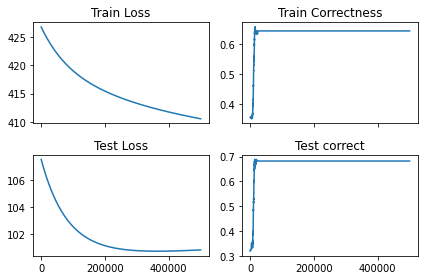

In [10]:
print("Final Training Correctness {:.2f}%".format(train_correct[-1]*100))
print("Final Test Correctness {:.2f}%".format(test_correct[-1]*100))
fig,ax = plt.subplots(2,2,sharex=True)
ax[0][0].plot(train_loss)
ax[0][0].set_title('Train Loss')
ax[0][1].plot(train_correct)
ax[0][1].set_title('Train Correctness')

ax[1][0].plot(test_loss)
ax[1][0].set_title('Test Loss')
ax[1][1].plot(test_correct)
ax[1][1].set_title('Test correct')
fig.tight_layout()

PyTorch Implementation

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


In [12]:
p_train = torch.from_numpy(train).float()
# p_train.size()
p_train_label = torch.from_numpy(train_label).float()
p_test = torch.from_numpy(test).float()
p_test_label = torch.from_numpy(test_label).float()


Final Training Correctness 65.15%
Final Test Correctness 62.99%


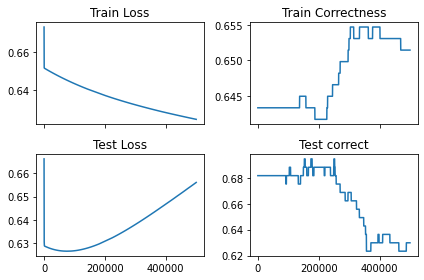

In [13]:
model = nn.Sequential(nn.Linear(8,1),
                      nn.Sigmoid())

# def weights_init(m):
#     if isinstance(m, nn.Linear):
#         torch.nn.init.xavier_uniform(m.weight.data)
# model.apply(weights_init)
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(),lr=0.02)
optimizer.zero_grad()
epoch = 500000
train_loss = []
train_correct = []
test_loss = []
test_correct = []
for i in range(epoch):
    p_train_pred = model(p_train)
    loss = criterion(p_train_pred,p_train_label)

    # Optional
    p_test_pred = model(p_test)
    t_loss = criterion(p_test_pred,p_test_label)

    # Calculate Gradient
    """
    By default,gradients are accumulated i.e.
    After each .backward() call, calculate the gradients
    and add them to previously stored gradients.
    We wish to calculate fresh gradients each time
    so set stored gradients to zero first.
    """
    optimizer.zero_grad()
    loss.backward()
    # Update weights based on gradients
    optimizer.step()

    # Optional Part
    train_loss.append(loss.item())
    p_train_correct = p_train_pred > 0.5
    train_correct.append(torch.mean(torch.eq(p_train_correct,p_train_label).float()).item())

    test_loss.append(t_loss.item())
    p_test_correct = p_test_pred > 0.5
    test_correct.append(torch.mean(torch.eq(p_test_correct,p_test_label).float()).item())

print("Final Training Correctness {:.2f}%".format(train_correct[-1]*100))
print("Final Test Correctness {:.2f}%".format(test_correct[-1]*100))
fig,ax = plt.subplots(2,2,sharex=True)
ax[0][0].plot(train_loss[100:])
ax[0][0].set_title('Train Loss')
ax[0][1].plot(train_correct[100:])
ax[0][1].set_title('Train Correctness')

ax[1][0].plot(test_loss[100:])
ax[1][0].set_title('Test Loss')
ax[1][1].plot(test_correct[100:])
ax[1][1].set_title('Test correct')
fig.tight_layout()